In [1]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import requests

# 1. Setup and pre-processing

In [2]:
PROJECT_CATEGORIES = json.load(open("data/categories.json"))
CATEGORIES = list(PROJECT_CATEGORIES.keys())
print(CATEGORIES)

['ETHEREUM_CORE_CONTRIBUTIONS', 'OP_STACK_TOOLING', 'OP_STACK_RESEARCH_AND_DEVELOPMENT']


In [3]:
flagged_ballots = [
    '0x2aa64e6d80390f5c017f0313cb908051be2fd35e',
    '0xf39fd6e51aad88f6f4ce6ab8827279cfffb92266',
    '0xdcde54571cd1d54e9172d0290b3ff2f65b566bbc',
    '0x92084bed8635d82db600e100539a61a6d4209403',
    '0xb42543cf0584f41f7af8e4e7c25349ad3ccd5e43',
    '0xe3b4b326d34686ea3a44dfa1e19e5ffd0dff04f3',
    '0x6aaa8733cfee3931d826c2d2ad4679db9accf6bb',
    '0x6df5195e2990bb29fb6e220df98dc26ebde9ed9a',
    '0x31f87f1475f81ccfff6a33a064cae812baeebcc6',
    '0x6b07602dbaacfd95d4a3a358438e39275538cc76',
    '0xe406938368062cc09f00c65278d209de5ac6dc4c'
]

In [4]:
def process_csv(csv_path):
    csv_data = pd.read_csv(csv_path)
    data = []
    for _, row in csv_data.iterrows():
        if row['Status'] == 'SUBMITTED':
            if row['Address'] in flagged_ballots:
                continue
            payload = json.loads(row['Payload'])
            projects_payload = payload['project_allocations']
            ballot_projects = []
            for votes in projects_payload:
                project_id = list(votes.keys())[0]
                ballot_projects.append(project_id)
            for cat, proj_list in PROJECT_CATEGORIES.items():
                if set(ballot_projects).intersection(proj_list):
                    payload.update({'category_assignment': cat})
                    break
            data.append(payload)
    return data

In [5]:
raw_voting_data = process_csv('data/_local/Early_data.csv')
NUM_VOTERS = len(raw_voting_data)
print("Ballots:", NUM_VOTERS)
print("\nSample Ballot:")
raw_voting_data[-1]

Ballots: 36

Sample Ballot:


{'budget': 8000000,
 'project_allocations': [{'0x8ce52931f5528de3a378ae58d1281083744b62b47dff98fcd71b54434fa840b5': '11'},
  {'0x078cf11f1d64911d10f1d57c1da9c09d67a167472afc530f3412c304ee0f239e': '11'},
  {'0xac859a911407aa694e23d1616d9ce086d3d53b90789186a94bfbbb8e7294036b': '9'},
  {'0xcd76f92636f76d63419d461b6e79cfc76979b24598d164226e90f27bd5ad996b': '8'},
  {'0xcf7477b956b4001b44a618139890f8decf0ad34ae55f0db1f01789040a17af0c': '7'},
  {'0x6c524b0afee6ab66e507b86f07f0338c5d1e5b7257c4b6fd80efdc56f30899df': '6'},
  {'0x3ba0b3e5456e209ea494e8f58197f3b46c20040a3cda99ae448fa355509132f4': '6'},
  {'0x38f4b51e1d89c1efce3c71fd155fa253d7fffe73cd239fcbd2f9309e4cc6e67b': '5'},
  {'0x2da519cc5be2bf70ab4fd79c979bf2d7d956e5a11be5eefb1f21d9363928d07f': '4'},
  {'0xa555f2cc261179e744f961525e3c506a0a53cc02389cb8d59b93c8a9220ed7d7': '4'},
  {'0xe8bfa7f5bee60dc487b7f61e9f95b933e7302383570de2339ff557f829140268': '3'},
  {'0x1ebd314438920197b1b37ab41de3678c4f7d5e0b844420527d5e0e2b437bed17': '4'},
  {'0x6

In [6]:
PROJECTS = list(set([
    list(p.keys())[0] for vote in raw_voting_data
    for p in vote['project_allocations']
]))
NUM_PROJECTS = len(PROJECTS)
print("Projects:", NUM_PROJECTS)

Projects: 79


# 2. Calculate median budget totals and category allocations

In [7]:
budget_allocation = []
category_scores = defaultdict(list)
project_scores = defaultdict(lambda: defaultdict(list))
for ballot in raw_voting_data:
    
    budget_allocation.append(ballot['budget'])
    assigned_category = ballot['category_assignment']

    for category_allocations in ballot['category_allocations']:
        category = list(category_allocations.keys())[0]
        category_percentage = float(list(category_allocations.values())[0])
        category_scores[category].append(category_percentage)

    for project_allocations in ballot['project_allocations']:
        project = list(project_allocations.keys())[0]
        project_percentage = list(project_allocations.values())[0]
        if pd.isnull(project_percentage):
            continue
        project_percentage = float(project_percentage)
        project_scores[assigned_category][project].append(project_percentage)

# Step 1A. Calculate total funding for the round based on median budget vote
median_total_budget = np.median(budget_allocation)
print(f"\nMedian Budget: {median_total_budget:,.0f}")

# Step 1B. Calculate medians for categories and normalize to weights across categories
category_medians = {k: np.median(v)/100 for k, v in category_scores.items()}    
category_total = sum(category_medians.values())
category_weights = {k: v/category_total for k, v in category_medians.items()}

# Step 2. Calculate medians for projects and normalize to weights within a category
project_weights = defaultdict(lambda: defaultdict(list))
for category, project_dict in project_scores.items():
    for project, scores in project_dict.items():
        project_weights[category][project] = np.median(scores) / 100
    category_subtotal = sum(project_weights[category].values())
    for k, v in project_weights[category].items():
        project_weights[category][k] = v/category_subtotal 

# Check the results makes sense

for c in CATEGORIES:
    print("\nCategory:", c)
    print("-----------------")
    print(f"Median Allocation: {category_weights[c]*100:.3f}%")
    print("Total Projects:", len(project_weights[c]))
#     for project in project_weights[c]:
#         print(f"{project}: {project_weights[c][project]*100:,.2f}%")
    print(f"Check: Sum of Project Allocations Within Category: {sum(project_weights[c].values())*100:.1f}%\n")


Median Budget: 8,000,000

Category: ETHEREUM_CORE_CONTRIBUTIONS
-----------------
Median Allocation: 39.801%
Total Projects: 30
Check: Sum of Project Allocations Within Category: 100.0%


Category: OP_STACK_TOOLING
-----------------
Median Allocation: 24.876%
Total Projects: 20
Check: Sum of Project Allocations Within Category: 100.0%


Category: OP_STACK_RESEARCH_AND_DEVELOPMENT
-----------------
Median Allocation: 35.323%
Total Projects: 29
Check: Sum of Project Allocations Within Category: 100.0%



# 3. Normalize and allocate funding

In [8]:
MIN_CAP = 1_000
MAX_CAP_PCT = .125
MAX_CAP = median_total_budget * MAX_CAP_PCT

In [9]:
# Step 3. Create an initial series of project funding allocations
initial_project_allocations = pd.Series()
for category, projects in project_weights.items():
    print("\nCategory:", category, category_weights[category])
    for project, score in projects.items():
        normalized_score = score * category_weights[category]
        #print(f"{project}: {normalized_score*100:.2f}%")
        initial_project_allocations.loc[project] = normalized_score * median_total_budget


Category: OP_STACK_TOOLING 0.24875621890547267

Category: ETHEREUM_CORE_CONTRIBUTIONS 0.3980099502487563

Category: OP_STACK_RESEARCH_AND_DEVELOPMENT 0.35323383084577115


Final Results:
 - Projects: 79
 - Voters: 36
 - Funding Available: 8000000.0
 - Funding Awarded: 8000000


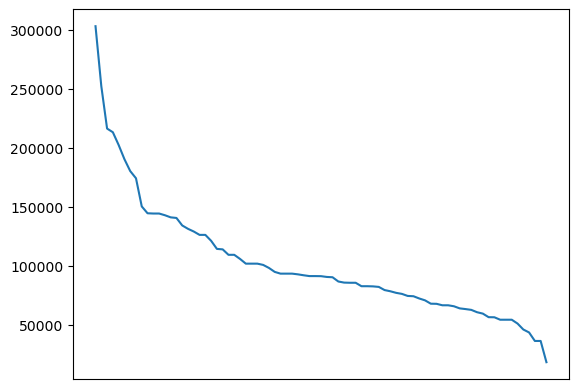

In [10]:
def allocate_funding(project_scores, funding_balance):
    """
    Helper for allocating and redistributing funding balances
    """
    score_balance = project_scores.sum()
    allocations = pd.Series()
    
    for project, score in project_scores.sort_values(ascending=False).items():
        uncapped_funding_alloc = score / score_balance * funding_balance
        capped_funding_alloc = min(uncapped_funding_alloc, MAX_CAP)
        allocations.loc[project] = capped_funding_alloc
        funding_balance -= capped_funding_alloc
        score_balance -= score

    return allocations

# Step 4. Implement max cap and redistribute excess
capped_allocations = allocate_funding(initial_project_allocations, median_total_budget)

# Step 5. Set the funding for projects below the minimum cap to 0
capped_allocations.loc[capped_allocations < MIN_CAP] = 0

# Step 6. Allocate the remaining funding to projects below the maximum cap
max_cap_funding = capped_allocations[capped_allocations == MAX_CAP].sum()
remaining_funding = median_total_budget - max_cap_funding
remaining_projects = capped_allocations[capped_allocations < MAX_CAP]
capped_allocations.update(allocate_funding(remaining_projects, funding_balance=remaining_funding))

#capped_allocations.to_csv('data/rf5_early_ballots_results.csv', header=['allocation'])

# Check the results
capped_allocations.plot(xticks=[])
print("Final Results:")
print(" - Projects:", NUM_PROJECTS)
print(" - Voters:", NUM_VOTERS)
print(" - Funding Available:", median_total_budget)
print(" - Funding Awarded:", round(capped_allocations.sum()))